# Imports and files

In [4]:
from pathlib import Path

import anndata as ad
import pandas as pd
import scanpy as sc
from utils import celltype_signatures

from sainsc import read_StereoSeq

In [5]:
data_path = Path("data")
analysis_path = Path("brain")

stereo_seq_file = data_path / "StereoSeq" / "Mouse_brain_Adult_GEM_bin1.tsv.gz"
stereo_seq_segmentation_file = data_path / "StereoSeq" / "Mouse_brain_cell_bin.h5ad"

de_genes_file = data_path / "ABC_atlas" / "DE_genes.xlsx"

In [6]:
analysis_path.mkdir(exist_ok=True, parents=True)

In [7]:
genes = (
    pd.read_excel(de_genes_file, sheet_name="DE_gene_list", header=None, names=["gene"])
    .loc[:, "gene"]
    .tolist()
)

len(genes)

8460

# Segmentation

In [4]:
segmentation = ad.read_h5ad(stereo_seq_segmentation_file)

## Signatures

In [ ]:
signatures = celltype_signatures(
    segmentation[:, segmentation.var_names.isin(genes)], celltype_col="annotation"
)

signatures.to_csv("StereoSeq_Brain_segmentation_signatures.tsv", sep="\t")

In [5]:
cmap = {
    "Astr1": "#BAAFFB",
    "Astr2": "#4E8817",
    "Astr3": "#787DA3",
    "Astr4": "#DA7879",
    "Astr5": "#E7CA2E",
    "DA neuron": "#656565",
    "Ependymal": "#5a0007ff",
    "EX": "#775613",
    "EX CA": "#4D86A3",
    "EX L2/3": "#4166AD",
    "EX L4": "#3D6B85",
    "EX L5/6": "#FAFF33",
    "EX L6": "#488854",
    "EX Mb": "#34347C",
    "EX thalamus": "#85CF5E",
    "Endothelium": "#CCC8FB",
    "Erythrocyte": "#94C351",
    "GN DG": "#8BC5ED",
    "IN Pvalb+": "#9c9a9b",
    "IN Pvalb+Gad1+": "#EED883",
    "IN Sst+": "#B88299",
    "IN thalamus": "#430B66",
    "IN Vip+": "#62AFC1",
    "Meninge": "#1B0083",
    "Microglia": "#525510",
    "OPC": "#A04540",
    "Olig": "#CB181B",
    "Smooth muscle cells": "#9FBDFB",
    "Unknown": "black",
}

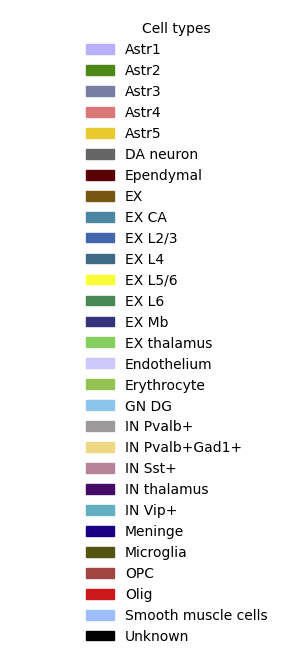

In [11]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

fig, ax = plt.subplots(figsize=(3, 7))

legend = [Patch(color=c, label=lbl) for lbl, c in cmap.items()]
_ = ax.legend(handles=legend, title="Cell types", frameon=False)
ax.set_axis_off()

fig.tight_layout()

In [12]:
fig.savefig(Path("figures") / "StereoSeq_Brain_segmentation_legend.pdf")

In [6]:
import json

with open("colormap_brain_publication.json", "w") as f:
    json.dump(cmap, f)

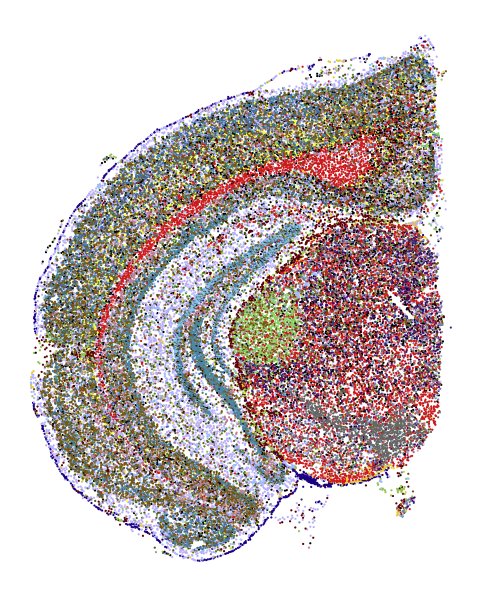

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(7.5, 7.5))
sns.scatterplot(
    x=segmentation.obsm["spatial"][:, 0] * -1,
    y=segmentation.obsm["spatial"][:, 1] * -1,
    hue=segmentation.obs["annotation"],
    palette=cmap,
    legend=False,
    linewidth=0,
    marker=".",
    ax=ax,
    s=10,
)
_ = ax.set(aspect=1)
_ = ax.set_axis_off()

In [29]:
fig.savefig(Path("figures") / "StereoSeq_Brain_segmentation.pdf")

# Determine usable area

This is probably easier done while reading the file binned which is much faster

In [8]:
stereo = read_StereoSeq(stereo_seq_file, resolution=500, n_threads=16)

print(stereo)

LazyKDE (16 threads)
    genes: 26177
    shape: (10500, 13950)
    resolution: 500.0 nm / px


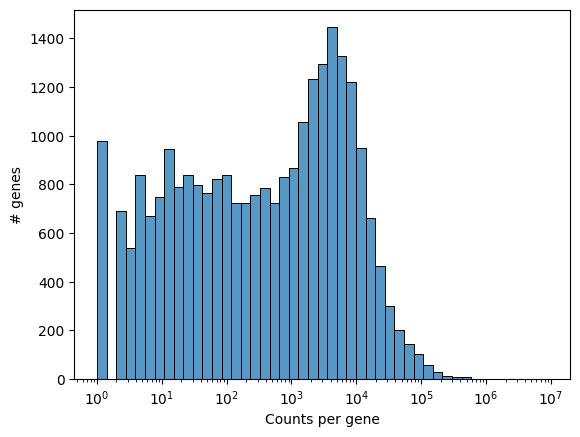

In [20]:
_ = stereo.plot_genecount_histogram()

In [32]:
stereo.gaussian_kernel(8)

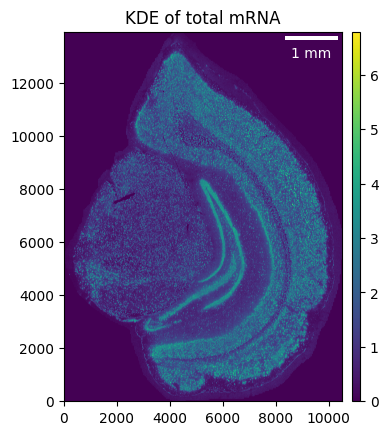

In [22]:
stereo.calculate_total_mRNA()
stereo.calculate_total_mRNA_KDE()

_ = stereo.plot_KDE()

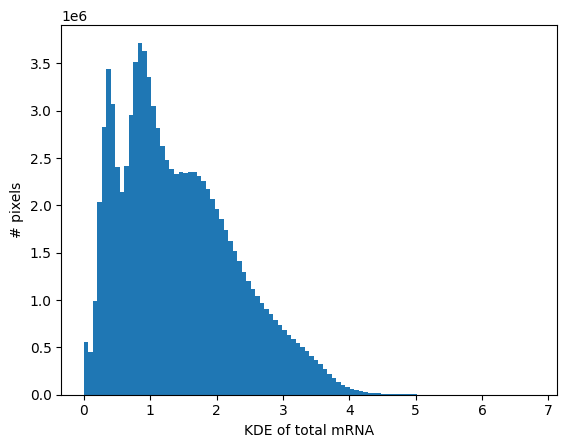

In [39]:
_ = stereo.plot_KDE_histogram(bins=100)

In [23]:
stereo.filter_background(1.3)

## Celltype assignment

In [26]:
signatures = signatures.loc[lambda df: df.index.isin(stereo.genes)]

stereo.assign_celltype(signatures, log=True)

print(stereo)

LazyKDE (16 threads)
    genes: 26177
    shape: (10500, 13950)
    resolution: 500.0 nm / px
    kernel: (33, 33)
    background: set
    celltypes: 29


In [27]:
import pickle

with open(analysis_path / "stereo_brain_seg_sigs_8k.pickle", "wb") as file:
    pickle.dump(stereo, file)

### thresholding

In [15]:
kde_per_celltype = pd.DataFrame(
    {
        "kde": stereo.total_mRNA_KDE.flatten(),
        "celltype": pd.Categorical.from_codes(
            stereo.celltype_map.flatten(), categories=stereo.celltypes
        ),
    }
).dropna()

celltype_threshold = (
    kde_per_celltype.groupby("celltype", observed=True).quantile(0.8)["kde"] / 3
).to_dict()

min_t = 0.7

celltype_threshold = {
    ct: (t if t > min_t else min_t) for ct, t in celltype_threshold.items()
}

stereo.filter_background(celltype_threshold)

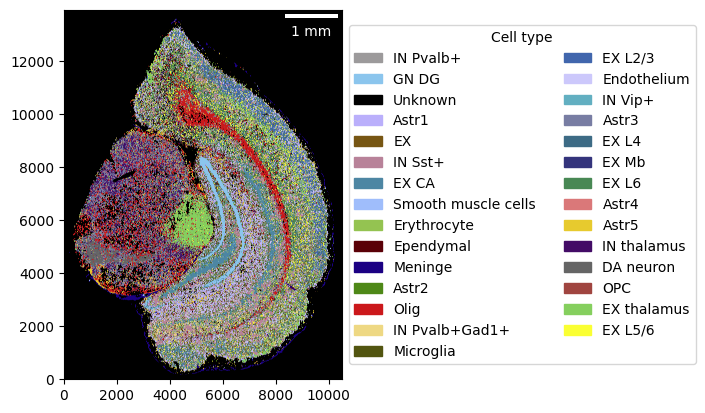

In [16]:
fig = stereo.plot_celltypemap(remove_background=True, cmap=cmap)

In [18]:
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
from scipy import ndimage

im = stereo.plot_celltypemap(
    remove_background=True, cmap=cmap, return_img=True, background="white"
)

rot_im = ndimage.rotate(im, -26, cval=255)

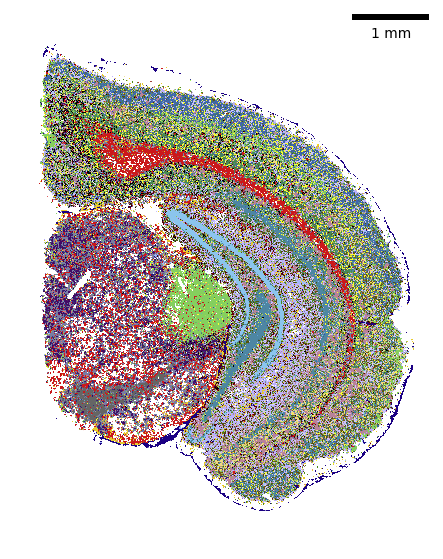

In [25]:
fig, ax = plt.subplots(figsize=(10, 7))

ax.imshow(rot_im[1_000:15_000, 3_000:14_000], origin="lower", interpolation="none")
ax.add_artist(
    ScaleBar(500, **{"units": "nm", "box_alpha": 0, "location": "upper right"})
)
ax.axis("off")

fig.savefig(Path("figures") / "StereoSeq_Brain.pdf", dpi=600)

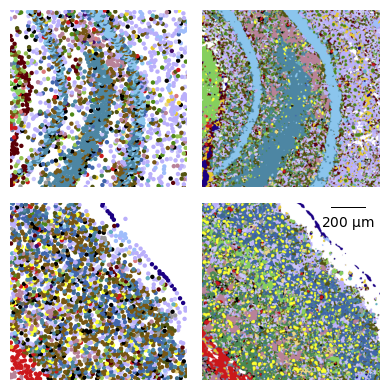

In [108]:
import seaborn as sns
from matplotlib.lines import Line2D

plt.ioff()

fig, axs = plt.subplots(2, 2, figsize=(4, 4))

section1 = segmentation[
    (segmentation.obsm["spatial"][:, 0] > 3000)
    & (segmentation.obsm["spatial"][:, 0] < 5000)
    & (segmentation.obsm["spatial"][:, 1] > -15000)
    & (segmentation.obsm["spatial"][:, 1] < -13000)
]

sns.scatterplot(
    x=section1.obsm["spatial"][:, 0],
    y=-1 * section1.obsm["spatial"][:, 1],
    hue=section1.obs["annotation"],
    legend=False,
    ax=axs[0, 0],
    palette=cmap,
    s=40,
    linewidth=0,
    marker=".",
)
axs[0, 0].set(aspect=1, xlim=(3000, 5000), ylim=(13000, 15000))
axs[0, 0].set_axis_off()

section2 = segmentation[
    (segmentation.obsm["spatial"][:, 0] > 5000)
    & (segmentation.obsm["spatial"][:, 0] < 7000)
    & (segmentation.obsm["spatial"][:, 1] > -18000)
    & (segmentation.obsm["spatial"][:, 1] < -16000)
]

sns.scatterplot(
    x=section2.obsm["spatial"][:, 0],
    y=-1 * section2.obsm["spatial"][:, 1],
    hue=section2.obs["annotation"],
    legend=False,
    ax=axs[1, 0],
    palette=cmap,
    s=40,
    linewidth=0,
    marker=".",
)
axs[1, 0].set(aspect=1, xlim=(5000, 7000), ylim=(16000, 18000))
axs[1, 0].set_axis_off()


axs[0, 1].imshow(rot_im[6100:8100, 8550:10550], origin="lower")
axs[0, 1].set_axis_off()

axs[1, 1].imshow(rot_im[9200:11200, 10400:12400], origin="lower")
axs[1, 1].set_axis_off()

_ = axs[1, 1].add_artist(
    ScaleBar(500, **{"units": "nm", "box_alpha": 0, "location": "upper right"})
)

plt.close(10)

fig.tight_layout()
fig

In [109]:
fig.savefig("figures/StereoBrain_segmentation_comparison.pdf", dpi=600)